In [145]:
import os, glob, sys
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow, imsave
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from ShowColors import *
from ImportUtil import *
%env CITYSCAPES_DATASET = /home/rvygon/data/

%load_ext autoreload
%autoreload 2

env: CITYSCAPES_DATASET=/home/rvygon/data/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
#run this cell once
#%run  cityscapesscripts/preparation/createTrainIdInstanceImgs
#%run  cityscapesscripts/preparation/createTrainIdInstanceImgs

In [147]:
x_val, y_val,files = importBatch(10,0,0,'val',scale = 4)
from keras.utils import to_categorical
y_val[y_val==255]=19
y_val = to_categorical(y_val)

In [140]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_pic(X, y):
    y[y==255]=19
    y=to_categorical(y)
    return X, y

def keras_generator(batch_size,scale):
    while True:
        batch_nums = np.random.randint(low=1000, high=2000, size=batch_size)
        batch_input = []
        batch_output = []
        
        for index in batch_nums:
            input_labels, input_images = getData(1, index,type='train')
            input_image = input_images[0]
            input_label = input_labels[0]           
            
            X_img = imread(input_image)
            if (scale != 0):
                X_new = np.zeros((int(X_img.shape[0] / scale), int(X_img.shape[1] / scale),3))
                k = 0
                for x in X_img[::scale]:
                    X_new[k]=x[::scale]
                    k+=1
                X_img = X_new
            y_img = imread(input_label)
            if (scale != 0):
                y_new = np.zeros((int(y_img.shape[0] / scale), int(y_img.shape[1] / scale)))
                k = 0
                for y in y_img[::scale]:
                    y_new[k] = y[::scale]
                    k += 1
                y_img = y_new
            
            X_img, y_img = preprocess_pic(X_img, y_img)
            
            batch_input.append(X_img)
            batch_output.append(y_img)
            
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)        
        yield batch_x, batch_y
        

In [114]:
#UNET https://github.com/zhixuhao/unet/blob/master/model.py
def unet(pretrained_weights = None,input_size = (256,512,3)):
    inputs = Input(input_size)
  
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)    
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))#drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(20, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [156]:
model =  load_model('unet_RV.hdf5')
generator = keras_generator(1,4)
model_checkpoint = ModelCheckpoint('unet_RV.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(generator,steps_per_epoch=1500,epochs=8,callbacks=[model_checkpoint], validation_data=(x_val,y_val),validation_steps=20)

ValueError: Error when checking target: expected conv2d_69 to have 4 dimensions, but got array with shape (500, 256, 512)

In [115]:
new_model = load_model('unet_RV.hdf5')
#new_model.summary()
model = new_model


10/10 [==============================] - 2s 172ms/step
(256, 512, 20)
[[128  64 128]
 [244  35 232]
 [ 70  70  70]
 [102 102 156]
 [190 153 153]
 [153 153 153]
 [250 170  30]
 [220 220   0]
 [107 142  35]
 [152 251 152]
 [ 70 130 180]
 [220  20  60]
 [255   0   0]
 [  0   0 142]
 [  0   0  70]
 [  0  60 100]
 [  0  80 100]
 [  0   0 230]
 [119  11  32]
 [  0   0   0]]


/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


[[19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 ...
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]]
[[    0 41923]
 [    1  3117]
 [    2 35262]
 [    8 10858]
 [    9   240]
 [   10  2338]
 [   11    28]
 [   13 23228]
 [   19 14078]]


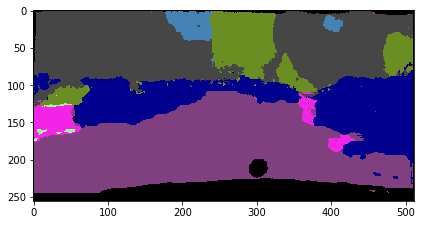

In [148]:
results = model.predict(x_val,verbose=1)
print(results[1].shape)
results = np.argmax(results,axis=3)
results=results.astype(int)
#res_image=np.argmax(results[0], axis=2)
colorImage(x_val[1], results[1], 'classes.txt', 'colors.txt')
print(results[1])
unique, counts = np.unique(results[1], return_counts=True)

print(np.asarray((unique, counts)).T)

In [149]:
x_pred=model.predict(x_val,verbose=1)
x_pred = np.argmax(x_pred,axis=3)
x_pred.shape

10/10 [==============================] - 1s 89ms/step


(10, 256, 512)

In [150]:
x_up = UpscaleImg(x_pred[0], 4,False)
x_up.shape

(1024, 2048)

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


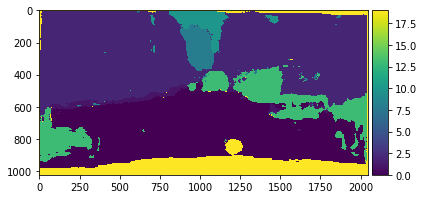

In [151]:
imshow(x_up)

In [152]:
x_val, y_val, filenames = importBatch(500,0,0,'val',4)
x_pred = model.predict(x_val,verbose=1)

500/500 [==============================] - 38s 76ms/step


In [153]:
new_x=np.argmax(x_pred,axis=3)
new_x.shape
new_new_x = np.zeros((new_x.shape[0],new_x.shape[1]*4,new_x.shape[2]*4))

In [154]:
for i in range(x_pred.shape[0]):
    new_new_x[i]=UpscaleImg(new_x[i],4,0)

In [157]:
new_new_x = new_new_x.astype(int)
def eval_model(model):    
        cityscapesPath = os.environ['CITYSCAPES_DATASET']        
        for i in range(len(filenames)):
            impath = os.path.join(cityscapesPath,'results', filenames[i].split('/')[7]+'.png')           
            imsave(impath, new_new_x[i])
%run cityscapesscripts/evaluation/evalPixelLevelSemanticLabeling
#eval_model(new_model)




    

Evaluating 500 pairs of images...
Images Processed: 500    

-------------- ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------- 
              |  u   |  e   |  r   |  o   |  s   |  d   |  g   |  r   |  s   |  p   |  r   |  b   |  w   |  f   |  g   |  b   |  t   |  p   |  p   |  t   |  t   |  v   |  t   |  s   |  p   |  r   |  c   |  t   |  b   |  c   |  t   |  t   |  m   |  b   | Prior |
-------------- ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------- 
    unlabeled | 0.00   0.00   0.17   0.00   0.00   0.00   0.00   0.00   0.02   0.00   0.80   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

      bicycle | 0.01   0.03   0.25   0.00   0.00   0.00   0.00   0.00   0.17   0.00   0.00   0.00   0.00   0.54   0.00   0.00   0.00   0.00   0.00   0.01   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  0.0062 
-------------- ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ -------  

classes          IoU      nIoU
--------------------------------
road          : 0.000      nan
sidewalk      : 0.002      nan
building      : 0.000      nan
wall          : 0.000      nan
fence         : 0.009      nan
pole          : 0.000      nan
traffic light : 0.001      nan
traffic sign  : 0.000      nan
vegetation    : 0.000      nan
terrain       : 0.000      nan
sky           : 0.000      nan
person        : 0.000      nan
rider         : 0.000      nan
car   

34


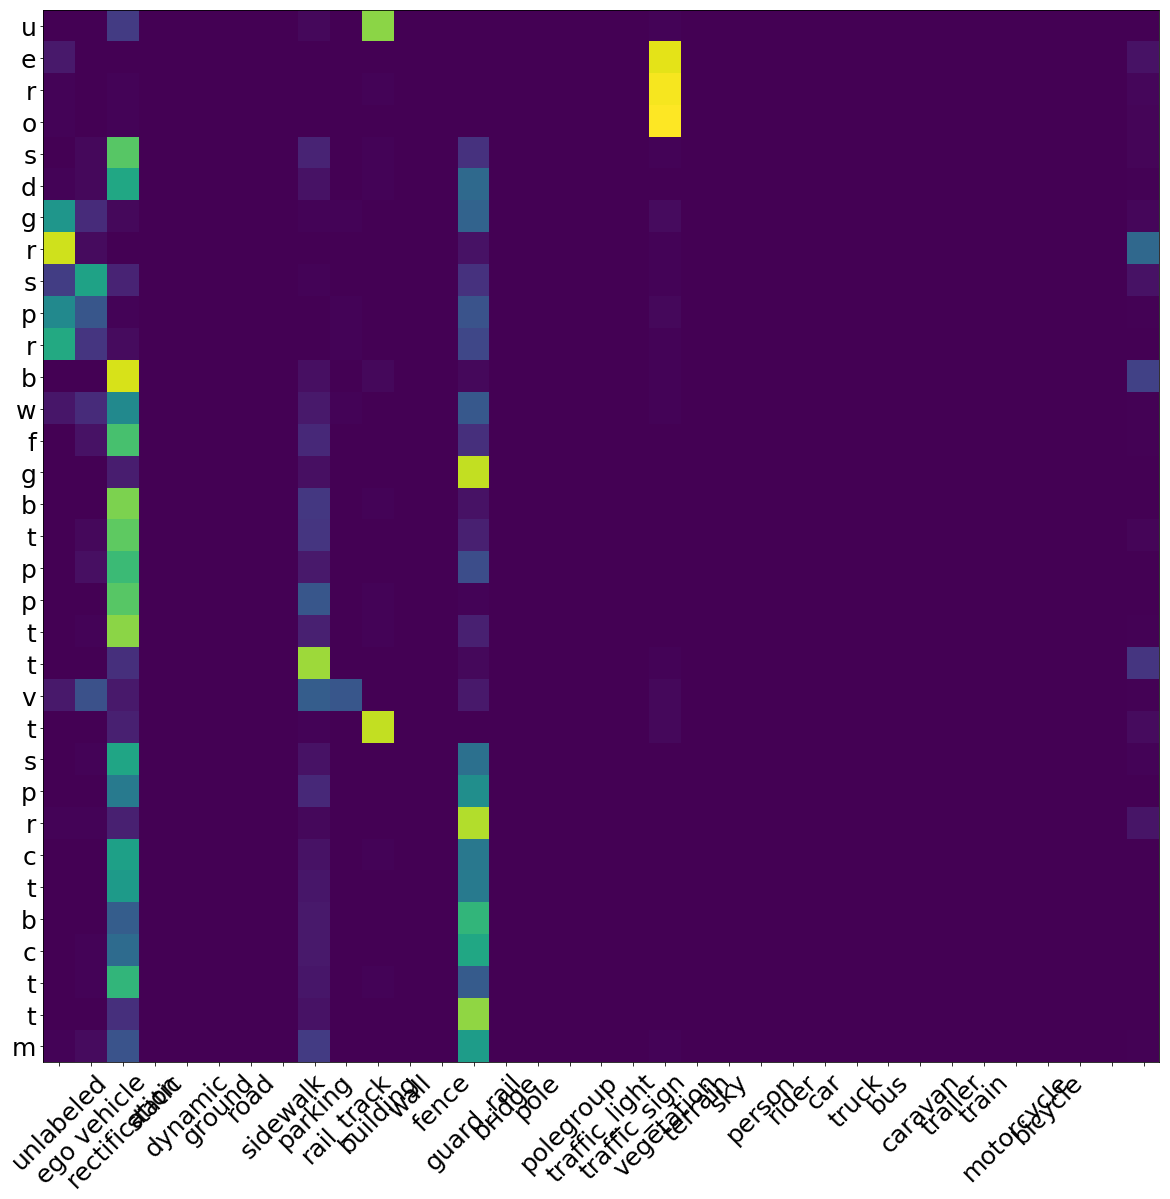

In [110]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False
with open('output.txt', 'r') as myfile:
    str=myfile.read().replace('\n', '')
#37
str=str.split('|')
str=str[37:70]
str[32]=str[32][:-1322]
a = []
for s in str:
    a.append(s.split(' '))
cl =[]
for k in a:
    cl.append([ x for x in k if isfloat(x) ])
mtrx = np.asarray(cl)
mtrx.shape
mt = np.zeros((33,35))
for i in range(33):
    for j in range(35):
        mt[i][j]=int(mtrx[i][j].astype('float32')*255)
plt.figure(figsize=(20, 20))
plt.imshow(mt)
strs=' |  u   |  e   |  r   |  o   |  s   |  d   |  g   |  r   |  s   |  p   |  r   |  b   |  w   |  f   |  g   |  b   |  t   |  p   |  p   |  t   |  t   |  v   |  t   |  s   |  p   |  r   |  c   |  t   |  b   |  c   |  t   |  t   |  m   |  b   ||'
strs=strs.split(' ')
strs = [x for x in strs if x.isalpha()]
print(len(strs))
sts =['unlabeled','ego vehicle','rectification','static','dynamic','ground','road','sidewalk','parking','rail_track','building','wall','fence','guard_rail','bridge','pole','polegroup','traffic_light','traffic_sign','vegetation','terrain','sky','person','rider','car','truck','bus','caravan','trailer','train','motorcycle','bicycle']
plt.xticks(np.arange(35), sts, rotation=45, fontsize=25)
plt.yticks(np.arange(33), strs, fontsize=25)
plt.show()


/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


IndexError: index 15 is out of bounds for axis 0 with size 10

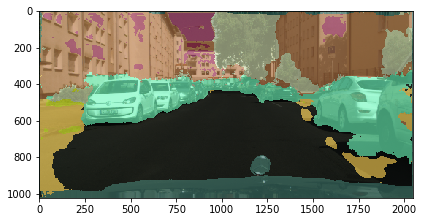

In [22]:
x_val.shape,new_new_x.shape

for i in [1,15,20,42]:
    colorImage(UpscaleImg(x_val[i],4,1), new_new_x[i], 'classes.txt')

In [23]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13621833291701252735, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11287530701
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5045510980413374096
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 74f6:00:00.0, compute capability: 3.7"]